# Import Dependencies

In [3]:
# install required system dependencies
!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install pyglet==1.5.11
!pip install pytorch-nlp

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 25.5 MB/s 
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.11
    Uninstalling pyglet-1.5.11:
      Successfully uninstalled pyglet-1.5.11
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyglet-1.5.11-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfull

In [4]:
# install python wrapper for Xvfb
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [5]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
#from itertools import count
from PIL import Image

import torch 
import torch.nn as nn #neural networks
import torch.optim as optim #optimization 
import torch.nn.functional as F #layers
import torchvision.transforms as T #utilities for vision tasks

# set up CartPole-v0 Gym environment
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN Model

## Baseline

In [49]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.fc1 = nn.Linear(2660, 100) 
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) # input layer
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Conv layer 1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # Conv layer 2
        x = x.view(-1, 2660) 
        x = F.relu(self.fc1(x))  # Dense layer 1 
        x = self.fc2(x) # Dense layer 2
        return F.log_softmax(x, dim=1) # output layer

## With DropOut

In [7]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.fc1 = nn.Linear(2660, 100) 
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) # input layer
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Conv layer 1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # Conv layer 2
        x = x.view(-1, 2660) 
        x = F.relu(self.fc1(x))  # Dense layer 1 
        x = F.dropout(x) # default p=0.5  
        x = self.fc2(x) # Dense layer 2
        return F.log_softmax(x, dim=1) # output layer

## With DropConnect

In [5]:
from torchnlp.nn import WeightDrop #WeightDropLinear

In [6]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.fc1 = nn.Linear(2660, 100) 
        weights = ['weight']
        self.fc1 = WeightDrop(nn.Linear(2660, 100), weights, 0.2)
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(-1, 2660) 
        x = F.relu(self.fc1(x)) #, training=self.training)) 
        #x = F.dropout(x, training=self.training) #default p=0.5     
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
'''class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(2660, 100) 
        weights = ['weight']
        self.fc1_drop = WeightDrop(self.fc1, weights, 0.2)
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(-1, 2660) 
        x = F.relu(self.fc1(x)) #, training=self.training)) 
        #x = F.dropout(x, training=self.training) #default p=0.5     
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)'''

## With DropConnect and DropOut

In [19]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.fc1 = nn.Linear(2660, 100) 
        weights = ['weight']
        self.fc1 = WeightDrop(nn.Linear(2660, 100), weights, 0.2)
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(-1, 2660) 
        x = F.relu(self.fc1(x)) #, training=self.training)) 
        x = F.dropout(x, training=self.training) #default p=0.5     
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## With Adaptive DropOut

In [4]:
from layers import Standout

In [5]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(2660, 100)
        #weights = ['weight']
        #self.fc1 = WeightDrop(nn.Linear(2660, 100), weights, dropout=0.2)
        self.fc1_drop = Standout(self.fc1, 0.5, 1) 
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(-1, 2660) 
        previous = x
        x_relu = F.relu(self.fc1(x)) #, training=self.training)) 
        x = self.fc1_drop(previous, x_relu)
        #x = F.dropout(x, training=self.training) #default p=0.5     
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## With DropConnect and Adaptive DropOut

In [7]:
from layers import Standout
from torchnlp.nn import WeightDrop

In [8]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        weights = ['weight']
        self.fc1 = WeightDrop(nn.Linear(2660, 100), weights, dropout=0.2)
        self.fc1_drop = Standout(self.fc1, 0.5, 1) 
        self.fc2 = nn.Linear(100, 2)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device) 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(-1, 2660) 
        previous = x
        x_relu = F.relu(self.fc1(x)) #, training=self.training)) 
        x = self.fc1_drop(previous, x_relu)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Experience Replay

In [15]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Input Extraction

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


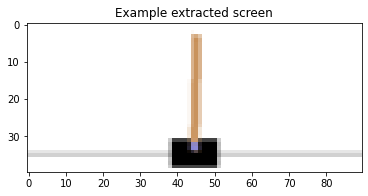

In [16]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Transpose returned screen dimensions it into torch order.
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    
    # Convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension
    return resize(screen).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), 
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Training

## Set Hyperparameters

In [17]:
BATCH_SIZE = 128
GAMMA = 0.999 
EPS_START = 0.9 
EPS_END = 0.85 #0.05
EPS_DECAY = 200 
TARGET_UPDATE = 10

## Train DQN

In [ ]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of the down-sampled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

## Select Action

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was found
            # so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

## Optimise Model

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch to converts batch-array of transitions
    # to transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, 
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then select the columns of actions taken. 
    # These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the older target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Training Loop & Results

In [13]:
import matplotlib.ticker as ticker

## Baseline

In [39]:
num_episodes = 1000
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

Episode #0 finished after 23 timesteps with total rewards 23.0
Episode #1 finished after 52 timesteps with total rewards 52.0
Episode #2 finished after 15 timesteps with total rewards 15.0
Episode #3 finished after 10 timesteps with total rewards 10.0
Episode #4 finished after 22 timesteps with total rewards 22.0
Episode #5 finished after 18 timesteps with total rewards 18.0
Episode #6 finished after 22 timesteps with total rewards 22.0
Episode #7 finished after 28 timesteps with total rewards 28.0
Episode #8 finished after 12 timesteps with total rewards 12.0
Episode #9 finished after 11 timesteps with total rewards 11.0
Episode #10 finished with avg. rewards 23
Episode #11 finished after 18 timesteps with total rewards 18.0
Episode #12 finished after 20 timesteps with total rewards 20.0
Episode #13 finished after 9 timesteps with total rewards 9.0
Episode #14 finished after 15 timesteps with total rewards 15.0
Episode #15 finished after 21 timesteps with total rewards 21.0
Episode #1

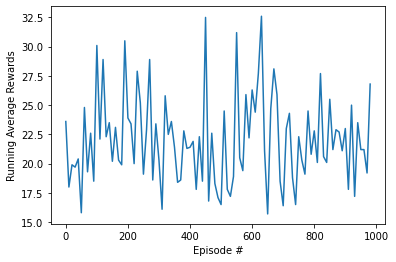

In [40]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

## With DropOut

### Large epsilon decay 
EPS_START = 0.9 
EPS_END = 0.5 

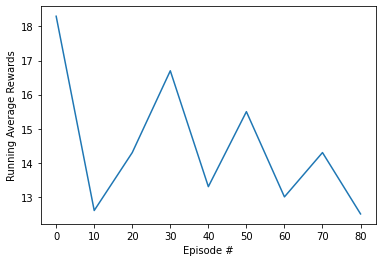

In [81]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

### Small epsilon decay
EPS_START = 0.9 
EPS_END = 0.85

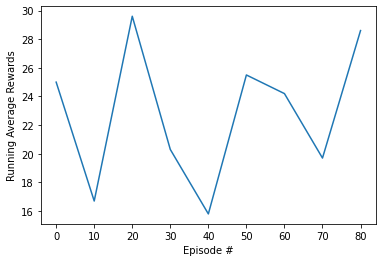

In [93]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

In [15]:
num_episodes = 1000
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

Episode #0 finished after 17 timesteps with total rewards 17.0
Episode #1 finished after 15 timesteps with total rewards 15.0
Episode #2 finished after 42 timesteps with total rewards 42.0
Episode #3 finished after 17 timesteps with total rewards 17.0
Episode #4 finished after 25 timesteps with total rewards 25.0
Episode #5 finished after 18 timesteps with total rewards 18.0
Episode #6 finished after 19 timesteps with total rewards 19.0
Episode #7 finished after 10 timesteps with total rewards 10.0
Episode #8 finished after 34 timesteps with total rewards 34.0
Episode #9 finished after 13 timesteps with total rewards 13.0
Episode #10 finished with avg. rewards 22
Episode #11 finished after 45 timesteps with total rewards 45.0
Episode #12 finished after 23 timesteps with total rewards 23.0
Episode #13 finished after 18 timesteps with total rewards 18.0
Episode #14 finished after 44 timesteps with total rewards 44.0
Episode #15 finished after 12 timesteps with total rewards 12.0
Episode 

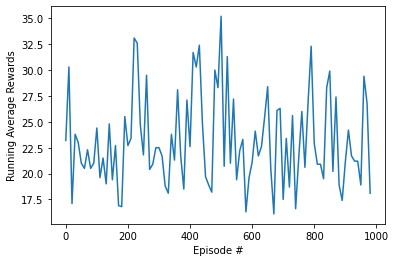

In [16]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

## With DropConnect

In [14]:
num_episodes = 500
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

Episode #0 finished after 14 timesteps with total rewards 14.0
Episode #1 finished after 15 timesteps with total rewards 15.0
Episode #2 finished after 21 timesteps with total rewards 21.0
Episode #3 finished after 18 timesteps with total rewards 18.0
Episode #4 finished after 38 timesteps with total rewards 38.0
Episode #5 finished after 9 timesteps with total rewards 9.0
Episode #6 finished after 31 timesteps with total rewards 31.0
Episode #7 finished after 16 timesteps with total rewards 16.0
Episode #8 finished after 16 timesteps with total rewards 16.0
Episode #9 finished after 75 timesteps with total rewards 75.0
Episode #10 finished with avg. rewards 14
Episode #11 finished after 36 timesteps with total rewards 36.0
Episode #12 finished after 34 timesteps with total rewards 34.0
Episode #13 finished after 12 timesteps with total rewards 12.0
Episode #14 finished after 56 timesteps with total rewards 56.0
Episode #15 finished after 30 timesteps with total rewards 30.0
Episode #1

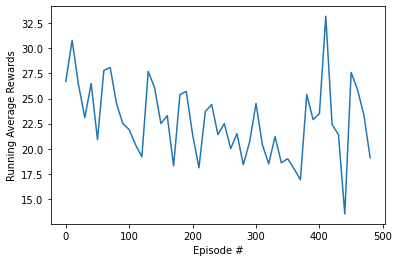

In [18]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

## With DropConnect and DropOut

In [26]:
num_episodes = 500
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

Episode #0 finished after 17 timesteps with total rewards 17.0
Episode #1 finished after 17 timesteps with total rewards 17.0
Episode #2 finished after 15 timesteps with total rewards 15.0
Episode #3 finished after 31 timesteps with total rewards 31.0
Episode #4 finished after 30 timesteps with total rewards 30.0
Episode #5 finished after 28 timesteps with total rewards 28.0
Episode #6 finished after 18 timesteps with total rewards 18.0
Episode #7 finished after 14 timesteps with total rewards 14.0
Episode #8 finished after 22 timesteps with total rewards 22.0
Episode #9 finished after 24 timesteps with total rewards 24.0
Episode #10 finished with avg. rewards 15
Episode #11 finished after 23 timesteps with total rewards 23.0
Episode #12 finished after 13 timesteps with total rewards 13.0
Episode #13 finished after 14 timesteps with total rewards 14.0
Episode #14 finished after 10 timesteps with total rewards 10.0
Episode #15 finished after 31 timesteps with total rewards 31.0
Episode 

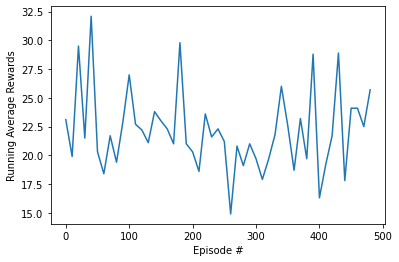

In [27]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

## With Adaptive DropOut

In [13]:
num_episodes = 1000
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

Episode #0 finished after 16 timesteps with total rewards 16.0
Episode #1 finished after 16 timesteps with total rewards 16.0
Episode #2 finished after 12 timesteps with total rewards 12.0
Episode #3 finished after 12 timesteps with total rewards 12.0
Episode #4 finished after 17 timesteps with total rewards 17.0
Episode #5 finished after 11 timesteps with total rewards 11.0
Episode #6 finished after 11 timesteps with total rewards 11.0
Episode #7 finished after 22 timesteps with total rewards 22.0
Episode #8 finished after 14 timesteps with total rewards 14.0
Episode #9 finished after 9 timesteps with total rewards 9.0
Episode #10 finished with avg. rewards 15
Episode #11 finished after 25 timesteps with total rewards 25.0
Episode #12 finished after 33 timesteps with total rewards 33.0
Episode #13 finished after 12 timesteps with total rewards 12.0
Episode #14 finished after 12 timesteps with total rewards 12.0
Episode #15 finished after 17 timesteps with total rewards 17.0
Episode #1

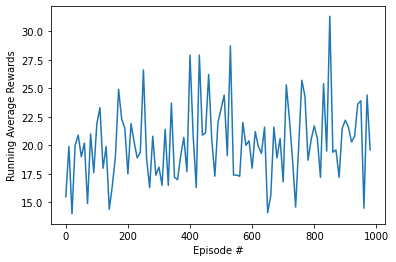

In [14]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()

## With DropConnect and Adaptive DropOut

In [ ]:
num_episodes = 500
average_reward_list = []
average_reward = 0

for episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    timestep = 0
    for t in range(200): #count():
        timestep += 1

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        average_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate running average over sliding window of 10
    if episode % 10 == 0 and episode != 0:
        average_reward_list.append(average_reward/10)
        print("Episode #{} finished with avg. rewards {}".format(episode, timestep, average_reward/10))
        average_reward = 0
    else:
        print("Episode #{} finished after {} timesteps with total rewards {}".format(episode, timestep, total_reward))
print('Complete')
env.render()
env.close()

In [ ]:
# Plot average rewards
plt.plot(average_reward_list)
plt.xlabel('Episode #')
plt.ylabel('Running Average Rewards')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10))
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.ioff()
plt.show()